### At-scale click through rate prediction with logistic regression and gbt 

#### Introduction
The purpose of this project is to build a classification model using Logistic Regression for Click Through Rate, CTR, using data provided by Criteo Labs as seen at https://www.kaggle.com/c/criteo-display-ad-challenge. More specifically, our aim will be to analyze the provided variables and create a set of transformations such that all together in the form of a model, can accurately predict whether or not a user has clicked or not clicked on a specific piece of advertisement. To do binary classification and from our review of literature and prior submissions on kaggle, logistic regression seems to be a popular choice. We mirror this approach and choose logistic regression as our main model because it is readily parallelizable, comprehensively simple, and again seems to have the most success within the research community. However, we are curious of other methods. As seen in this article: https://towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5, gradient boosted trees have found success in similar datasets where the labels may be unbalanced. A *question* we have is how do these methods compare in performance. Therefore, we use a similar approach to highlight this and contrast the results we achieve with that of our logistic results.

We believe this exercise to be important for several reasons. Firstly, it is informative from a data science perspective to see how different algorithms perform. Secondly, at a higher level it is insightful to see what variables and in what form contribute most to a users preference to click and not click. Obviously, this has immense real-world applications. For instance, this insight would better inform marketers how to better tailor their ads for the general consumer. 

We use standard confusion matrix metrics as our evaluation tool. In particular, accuracy, recall, precision, and f1-score are important to us. Accuracy will give us a general sense of the matches however we want to be conscious of actual signal detection over any noise therefore recall and precision will also be an important metric for us. F1-score will give us a combined opinion in regards to both positive and negative labels. We look to both accuracy and f1-score as a high level indicator of our success. In additio

__*The layout*__ of this report will be the creation of toy, train, and validation datasets followed by an Exploratory Data Analysis (EDA) where we present 2-3 potential problems. From the EDA, we will select the variables and prepare them for modeling through a series of transformations. This will then be fed into our algorithm and evaluated using the techniques as specified above. The algorithm is explained before it is ran. Feature engineering, modeling, and evaluation will be somewhat of an iterative process. This will be followed by a discussion, application of core concepts and concluding thoughts and recommendations. 

*This project was done by Praba Santhanakrishnan, Tennison Yu, Jonathan Zhou as part of the MIDS program. Please reference if this work is done to build on this.*

#### Packages and Initial Instantiations

In [1]:
import sys
import re
import ast
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from pyspark.sql import SparkSession
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from IPython.display import display, HTML

PWD = !pwd
PWD = PWD[0]
pd.set_option('display.max_columns', 500)

In [31]:
%reload_ext autoreload
%autoreload 2

In [3]:
app_name = "ctr_prediction"
master = "local[*]"
spark = SparkSession.builder.appName(app_name).master(master).getOrCreate()
sc = spark.sparkContext

In [33]:
# Reading the created toy/test dataset.
toy = pd.read_csv('test_data/toydata.txt', sep ='\t', header=None)
train = pd.read_csv('test_data/testdata.txt', sep ='\t', header=None)
val = pd.read_csv('test_data/valdata.txt', sep ='\t', header=None)
#fullTrain = pd.read_csv('data/train.txt', sep ='\t', header=None)

In [4]:
# Load data locally
fullTrainRDD = sc.textFile('data/train.txt')
sampleTrainRDD = sc.textFile('test_data/testdata.txt')
valRDD = sc.textFile('test_data/valdata.txt')
toyRDD = sc.textFile('test_data/toydata.txt')

#### Preparing Sample Datasets

In [ ]:
# This function is used to sample k rows randomly from the initial file.
def random_sampler(filename, k):
    sample = []
    
    with open(filename, 'rb') as f:
        f.seek(0, 2)
        filesize = f.tell()
        random_set = sorted(random.sample(range(filesize), k))

        for i in range(k):
            f.seek(random_set[i])
            f.readline() # Skip current line (because we might be in the middle of a line)   
            sample.append(f.readline()) # Append the next line to the sample set 

    return sample

In [ ]:
test_sample = random_sampler(PWD + '/data/train.txt', 10000)
f = open(PWD + '/test_data/testdata.txt', 'w')
f.writelines(["%s" % item.decode("utf-8")  for item in test_sample])

val_sample = random_sampler(PWD + '/data/train.txt', 2000)
f = open(PWD + '/test_data/valdata.txt', 'w')
f.writelines(["%s" % item.decode("utf-8")  for item in val_sample])

toy_sample = random_sampler(PWD + '/data/train.txt', 100)
f = open(PWD + '/test_data/toydata.txt', 'w')
f.writelines(["%s" % item.decode("utf-8")  for item in toy_sample])

In [23]:
!wc -l test_data/toydata.txt
!wc -l test_data/testdata.txt
!wc -l test_data/valdata.txt

100 test_data/toydata.txt
10000 test_data/testdata.txt
2000 test_data/valdata.txt


Each of these sets were created from the original dataset named **train.txt**. Given the number of rows in the above line count everything seems to have been created successfully. Note that the original dataset may not be in the github repo due to its size. We also note here that because it is not required to submit our results to www.kaggle.com the provided **test.txt** was not used.

The purpose of the toy set will be for simple development and troubleshooting. The purpose of the train set will be to do exploratory data analysis, make initial decisions off of, and to train models on. The purpose of the validation dataset is to verify the models that we've trained.

#### General Exploratory Data Analysis (EDA)

From this point onward we will use the test dataset to explore the data for any standout features. Much of the initial exploratory analysis will be done mostly using pandas dataframes.

In [24]:
train.head(3)

0    1   2    3     4       5     6    7     8     9    10   11  12    13  \
0   1  NaN   0  6.0   3.0   885.0   NaN  0.0   3.0   3.0  NaN  0.0 NaN   3.0   
1   0  0.0  95  8.0  11.0  1546.0  83.0  2.0  16.0  77.0  0.0  2.0 NaN  11.0   
2   0  NaN  95  1.0   1.0  3237.0   6.0  6.0   4.0   5.0  NaN  1.0 NaN   1.0   

         14        15        16        17        18        19        20  \
0  87552397  287130e0  817ffd64  2d9ebdbb  4cf72387  7e0ccccf  74f39215   
1  05db9164  95e2d337  0a1435c1  bdcfffba  25c83c98  7e0ccccf  4feec62c   
2  fb056015  5dac953d  d032c263  c18be181  25c83c98  7e0ccccf  1327309b   

         21        22        23        24        25        26        27  \
0  37e4aa92  a73ee510  3b08e48b  294d16d7  a63fcb59  fa17cc68  07d13a8f   
1  5b392875  a73ee510  3b08e48b  37fba4a7  5a276398  0fd466ce  b28479f6   
2  5b392875  a73ee510  0a197c54  fd0ccae7  dfbb09fb  17531d4f  1adce6ef   

         28        29        30        31        32        33        34   35  \
0  10040656  f10cfb5c  776ce399  891589e7  f30f7842  a458ea53  6a0f346c  NaN   
1  c57dc31f  4da40ea2  07c540c4  e1b6ea80  21ddcdc9  5840adea  290c14f6  NaN   
2  dd72d95b  84898b2a  e5ba7672  2c98cd83       NaN       NaN  0014c32a  NaN   

         36        37        38        39  
0  be7c41b4  6b4edae7  46fbac64  8379ffe4  
1  32c7478e  ded4aac9  2bf691b1  bdf46dce  
2  3a171ecb  3b183c5c       NaN       NaN

The dataset appears to contain the labels in the first column, followed by a series of columns with integer values and then a series of anonymized categorical columns as well. This seems to correspond to the provided data description on the kaggle link mentioned previously. Its mentioned that there would be 13 columns of integer data and 26 of categorical data. This is further validated using code 1 in the appendix which shows the data type of each column. The first 13 are either integer or floats whereas the next 26 are objects.

Notable as well is the number of null/NaN values throughout the dataset. The extent of this is something useful to check since it could impact which features may be important.

In [41]:
# Sum up the number of nulls and find the percentage
traindf = pd.DataFrame(train.isnull().sum(axis = 0)).transpose()
traindf.index = ['Number Nulls']
traindf.loc['Number Non-Nulls'] = train.shape[0] - traindf.loc['Number Nulls']
traindf.loc['Null Percent'] = round(traindf.loc['Number Nulls']/train.shape[0],3)
traindf

0         1        2        3         4         5   \
Number Nulls          0.0  4546.000      0.0  2096.00  2120.000   276.000   
Number Non-Nulls  10000.0  5454.000  10000.0  7904.00  7880.000  9724.000   
Null Percent          0.0     0.455      0.0     0.21     0.212     0.028   

                        6         7         8         9         10        11  \
Number Nulls      2234.000   419.000     6.000   419.000  4546.000   419.000   
Number Non-Nulls  7766.000  9581.000  9994.000  9581.000  5454.000  9581.000   
Null Percent         0.223     0.042     0.001     0.042     0.455     0.042   

                       12        13       14       15        16        17  \
Number Nulls      7705.00  2120.000      0.0      0.0   349.000   349.000   
Number Non-Nulls  2295.00  7880.000  10000.0  10000.0  9651.000  9651.000   
Null Percent         0.77     0.212      0.0      0.0     0.035     0.035   

                       18        19       20       21       22       23  \
Number Nulls          0.0  1248.000      0.0      0.0      0.0      0.0   
Number Non-Nulls  10000.0  8752.000  10000.0  10000.0  10000.0  10000.0   
Null Percent          0.0     0.125      0.0      0.0      0.0      0.0   

                       24        25       26       27       28        29  \
Number Nulls          0.0   349.000      0.0      0.0      0.0   349.000   
Number Non-Nulls  10000.0  9651.000  10000.0  10000.0  10000.0  9651.000   
Null Percent          0.0     0.035      0.0      0.0      0.0     0.035   

                       30       31        32        33        34       35  \
Number Nulls          0.0      0.0  4380.000  4380.000   349.000  7603.00   
Number Non-Nulls  10000.0  10000.0  5620.000  5620.000  9651.000  2397.00   
Null Percent          0.0      0.0     0.438     0.438     0.035     0.76   

                       36        37        38        39  
Number Nulls          0.0   349.000  4380.000  4380.000  
Number Non-Nulls  10000.0  9651.000  5620.000  5620.000  
Null Percent          0.0     0.035     0.438     0.438

Here, the train case shows that the number of nulls can very greatly depending on the column. For instance, column 12 and 35's null values make up >75% of the data. This is quite staggering since it raises challenges of backfilling and what features like this could mean. This is especially true for categorical variables since its anonymized. This leads us to a related question which is if all the data points are unique. 

In [27]:
# Sum up the number of distinct and find the percentage
traindf = pd.DataFrame(train.nunique()).transpose()
traindf.index = ['Number Distinct']
traindf.loc['Distinct Percent'] = round(traindf.loc['Number Distinct']/train.shape[0],3)
traindf

0       1        2        3       4        5        6   \
Number Distinct   2.0  71.000  853.000  273.000  63.000  5503.00  753.000   
Distinct Percent  0.0   0.007    0.085    0.027   0.006     0.55    0.075   

                       7       8        9      10      11      12      13  \
Number Distinct   281.000  58.000  770.000  6.000  56.000  33.000  91.000   
Distinct Percent    0.028   0.006    0.077  0.001   0.006   0.003   0.009   

                       14       15        16        17      18     19  \
Number Distinct   175.000  392.000  5954.000  4225.000  57.000  8.000   
Distinct Percent    0.018    0.039     0.595     0.422   0.006  0.001   

                        20      21   22        23        24       25  \
Number Distinct   3358.000  100.00  3.0  3309.000  2172.000  5601.00   
Distinct Percent     0.336    0.01  0.0     0.331     0.217     0.56   

                        26      27        28        29     30        31  \
Number Distinct   1812.000  24.000  2140.000  5020.000  9.000  1238.000   
Distinct Percent     0.181   0.002     0.214     0.502  0.001     0.124   

                       32   33        34     35      36        37      38  \
Number Distinct   545.000  3.0  5329.000  8.000  15.000  2662.000  39.000   
Distinct Percent    0.054  0.0     0.533  0.001   0.002     0.266   0.004   

                        39  
Number Distinct   2012.000  
Distinct Percent     0.201

Looking at the data, there is a range of uniqueness within the data. Looking at the train data specifically, column 16 has many different unique values whereas column 33 likely only has a couple unique values.

#### Numerical Exploratory Data Analysis

In [28]:
# Output descriptive statistics
train[list(range(0,14))].describe()

0            1             2             3            4   \
count  10000.000000  5454.000000  10000.000000   7904.000000  7880.000000   
mean       0.258400     3.359919    104.882200     26.452050     7.248350   
std        0.437777     8.216898    389.837031    232.085426     8.537747   
min        0.000000     0.000000     -2.000000      0.000000     0.000000   
25%        0.000000     0.000000      0.000000      2.000000     2.000000   
50%        0.000000     1.000000      3.000000      6.000000     4.000000   
75%        1.000000     3.000000     33.000000     18.000000     9.000000   
max        1.000000   154.000000   6423.000000  14566.000000    79.000000   

                 5             6            7            8            9   \
count  9.724000e+03   7766.000000  9581.000000  9994.000000  9581.000000   
mean   1.934517e+04    114.607520    16.339944    12.482890   106.816721   
std    7.187803e+04    326.166845    64.001228    13.418263   234.186625   
min    0.000000e+00      0.000000     0.000000     0.000000     0.000000   
25%    3.290000e+02      8.000000     1.000000     2.000000    10.000000   
50%    2.818000e+03     32.000000     3.000000     7.000000    38.000000   
75%    1.005500e+04    102.000000    11.000000    19.000000   109.000000   
max    1.364139e+06  12415.000000  2027.000000   225.000000  5871.000000   

                10           11           12           13  
count  5454.000000  9581.000000  2295.000000  7880.000000  
mean      0.614228     2.679261     1.042702     8.149746  
std       0.683882     5.015939     5.468457    11.397965  
min       0.000000     0.000000     0.000000     0.000000  
25%       0.000000     1.000000     0.000000     2.000000  
50%       1.000000     1.000000     0.000000     4.000000  
75%       1.000000     3.000000     1.000000    10.000000  
max       5.000000   108.000000   185.000000   214.000000

With the above statistics, there are a few notable observations. They are presented below along with the potential problems they can cause. 
- The counts confirm the magnitude of null values there are. This will need to be handled somehow as blank values can't be modeled. This is particularly tricky because not all the null values appear in the same row.
- The range and magnitude of values between different columns is quite significant. Column 5 for instance has values in the millions whereas column 10 has values with a max of 5. Therefore normalization will be a key transformation moving forward. Otherwise, gradient descent may not converge properly.
- Column 2 has negative values which is interesting since kaggle states that these should be counts and that when a value is missing, it is listed as empty. This result also poses a potential challenge for log transformations. 
- There appears to be a tremendous right skew. At 75% of the data, values are fairly small compared to their max. As well, the mean of most columns is greater than the median thereby supporting this fact.

To get a better sense of the above observations, boxplots, histograms and correlation plots were ran below. Note that just the train set was run because it contains many more datapoints and so would be a better representation of the larger dataset. 

In [29]:
# Make Boxplot
def make_boxplot(df):
    normalized_df=(df-df.mean())/(df.std())
    normalized_df.boxplot()

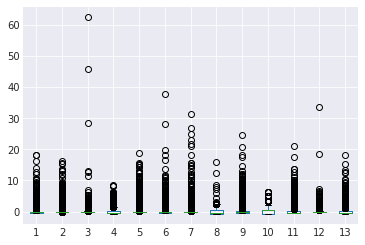

In [30]:
make_boxplot(train[list(range(1,14))])

To make the boxplot above, each field was range-normalized to express all values between 0 and 1. The large number of points above the outlier tails confirms the significant presence of right-skewness as remarked on previously for many of the features. Column 3, 6 and 7 illustrate this well given how compressed their respective boxplots are. Column 10 is worth noting since as seen above, it really only seems to have 5 values. It is curious what this column may represent.

In [31]:
# Make histogram grid
def hist_grid(df, rows, columns, log = False):
    
    # Defining plot layout
    fig, axs = plt.subplots(rows, columns, figsize=(15,10))
    r = 0
    c = 0
    
    for x in df.columns:
        
        # Dropping NAs and replacing 0, -1, -2 with 0.01 incase logging is necessary
        if not log:
            data = np.array(df[x].dropna()) 
        else:
            data = np.log(np.array(df[x].dropna().replace([0, -1, -2], 0.01)))
        
        # Getting the max values for binning purposes
        max_value = np.amax(data)
        axs[r,c].set_title('Column ' + str(x))

        # Graphing instructions for different column
        if x in [0, 4, 10]:
            axs[r,c].hist(data)
            
        elif x in [1, 2, 8, 11, 12, 13]:
            axs[r,c].set_xlim([0,max_value*0.05])
            axs[r,c].hist(data, bins = int(len(data)*0.5))
            
        else:
            axs[r,c].set_xlim([0,max_value*0.01])
            axs[r,c].hist(data, bins = int(len(data)*0.2))

        # Update the plot layout position
        r = r + 1 if c == columns-1 else r + 0
        c = c + 1 if c < columns-1 else 0
    
    plt.subplots_adjust(hspace = 1.5)

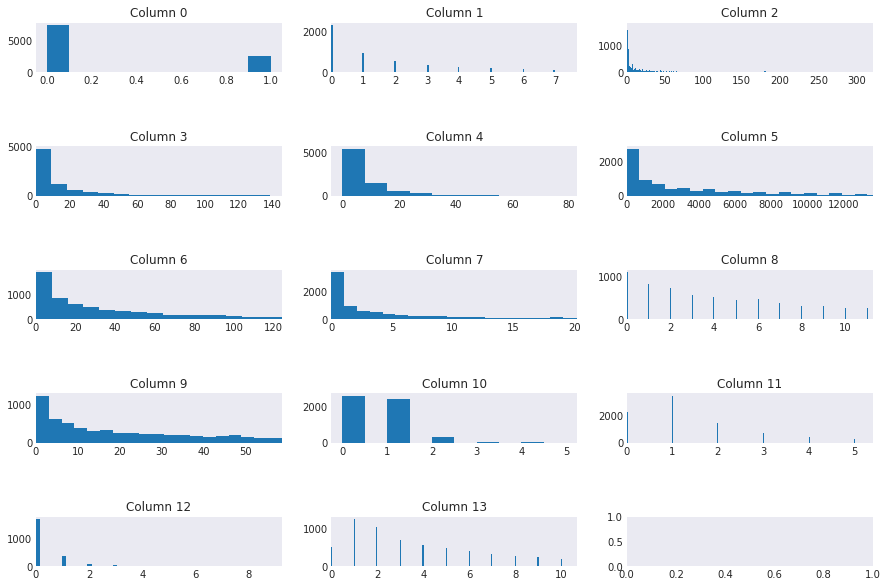

In [32]:
hist_grid((train[list(range(0,14))]), 5, 3, log=False)

Above, histograms were created to represent the labels as well as each of the integer features. There is code to adjust the x-axis of each feature's histogram in order to show the major distribution. Otherwise, because of the right skew, there would only be 1-2 bars. In the result, we can still see the right skewness of each of the data points. 

Histograms typically are well suited to highlight the skewness problem and in light of this, we also attempted to generated log-transformed version of each of these graphs. They are seen in the appendix. After doing this, columns 6, 7, 8, 9 and 13 seem to be much more normal after undergoing a log transform. However in doing so, we noted the prevalence of 0s throughout each feature. As seen in the code above, we accounted for this by replacing such values (along with negative values) with a value of 0.01. This works but the replacement value was chosen abstractly and it lead to a value of -4 in the data which could have a tremendous impact. It is not clear what would be a good replacement value instead since there is an inherent dependency on the overall range of the respective feature's values that the 0s belong to. Therefore, logging overall may not be an appropriate solution.

A final result to highlight are the labels. As can be seen there are noticeably less positive values compared to negative values. This could pose a problem in terms of data balance. If a dataset is unbalanced, our algorithm may not learn how to recognize positive samples appropriately. Typical techniques for this include undersampling the negative data or upsampling the positive data to match the negatives in count. Both of these will be considered. 

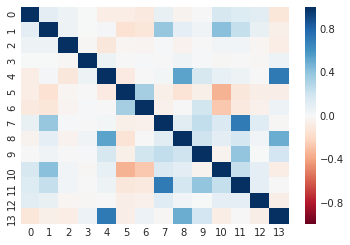

In [33]:
# Prepare correlation plots
corr_mat = train.corr()
sns.heatmap(corr_mat, xticklabels=corr_mat.columns, yticklabels=corr_mat.columns, cmap='RdBu', vmin=-1)

Looking at the results, we note the darker points listed below. These points look like they are fairly correlated and therefore it would be best to only have one of each pairing so as to avoid multi-colinearity. Interestingly, there appear to be two main groups in terms of the correlations. 

__Group 1__
- 4 & 13, 8 & 13, 4 & 8

__Group 2__
- 7 & 11, 5 & 10, 6 & 10, 1 & 10, 5 & 6, 1 & 7 

From here, we list the columns based on preference. The columns in tier 1 are our preferred because they generally have a low null count and seem more or less independent amongst themselves. Column 8 and 6 were chosen as representatives of their respective groups. Column 3 was chosen because although being very highly distributed it doesn't seem to have any correlation with other variables. Column 9 seems like it should be a general catch-all in terms of variation among a number of different variables. 

The other columns such as those in tier 2 columns are worth considering and we may be revisit these but they are left out now primarily because of issues revolving around high correlation with tier 1 columns, colinearity, and/or the amount of null values. The tier 3 columns are ones that are generally least preferred due to the same reasons as tier 2 but at a higher level.

| Tier 1 | Tier 2 | Tier 3 |
|--------|--------|--------|
|3, 6, 8, 9| 4,5,7,13 |1,2,10,11,12|


#### Categorical Exploratory Data Analysis

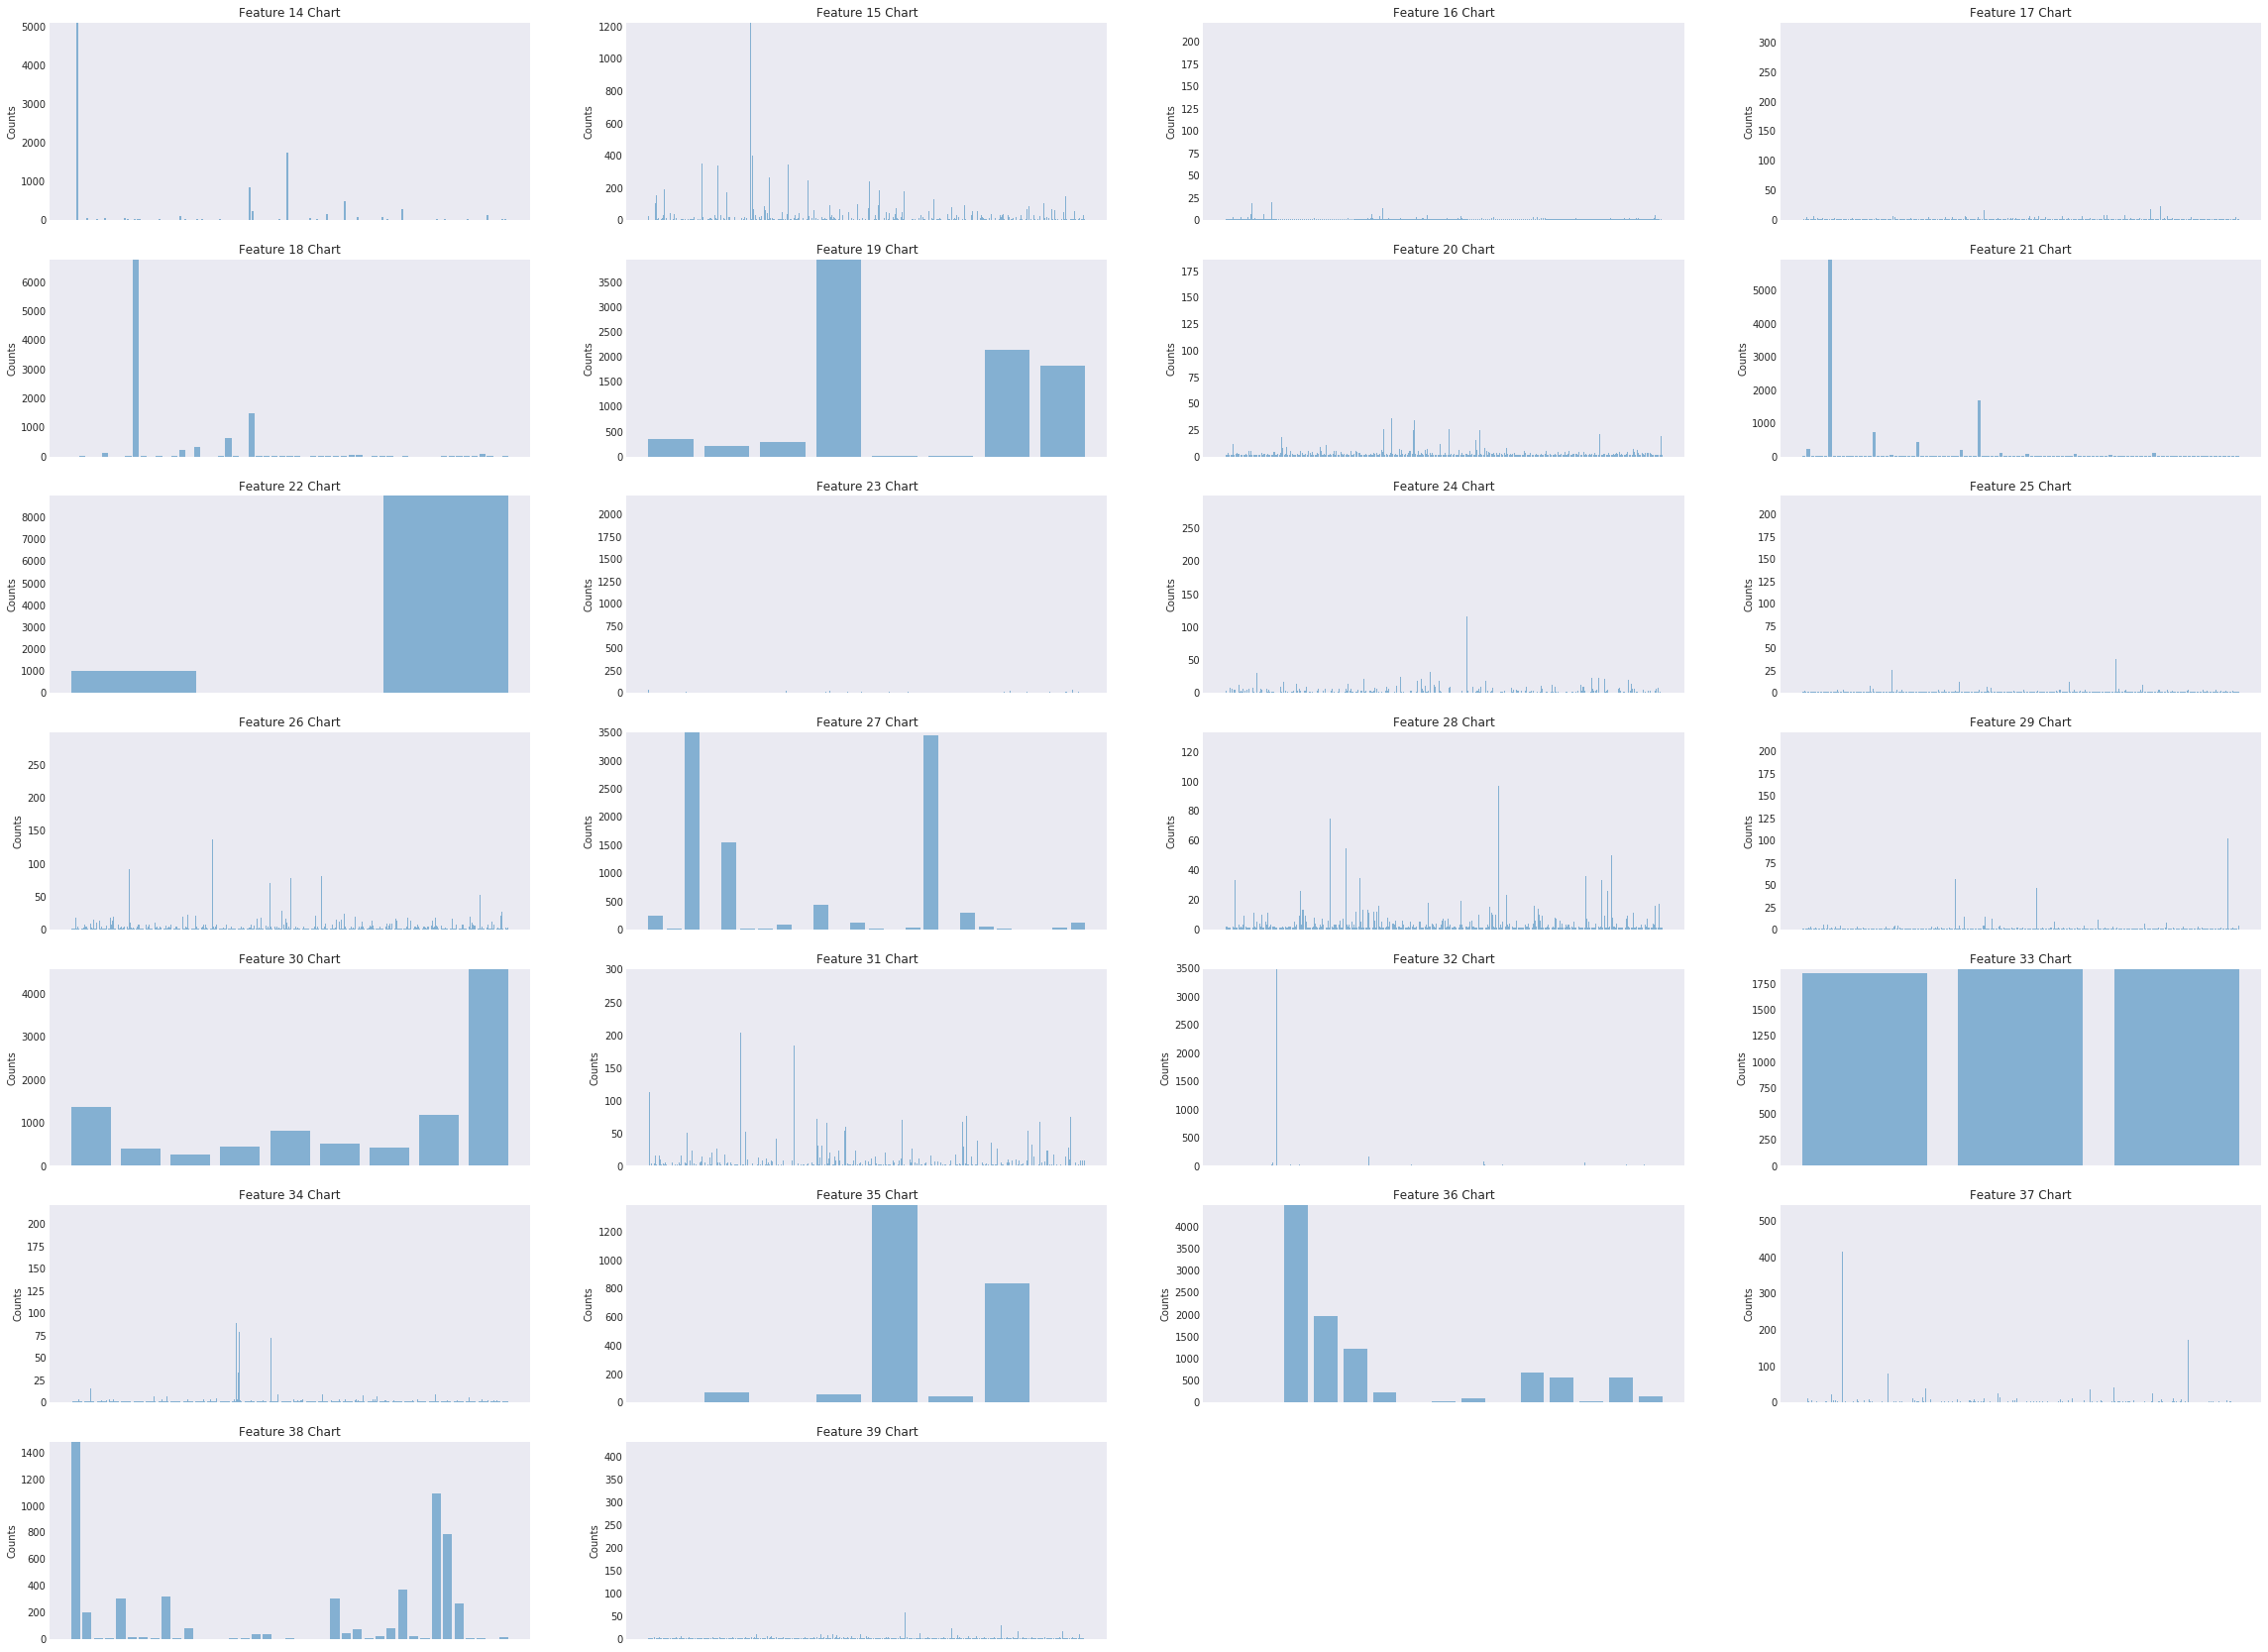

In [34]:
# Make bar plot of counts of each distinct value
plt.figure(figsize=(40, 30))

for i in range(26):
    plt.subplot(7, 4, i+1)
    count_list = train.groupby(by=i+14)[i+14].count().tolist()
    plt.bar(np.arange(len(count_list)), count_list, align='center', alpha=0.5)
    plt.ylabel('Counts')
    plt.xticks([], [])
    plt.ylim((0,np.amax(count_list)))
    plt.title('Feature ' + str(i+14) + ' Chart')

plt.show()

For categorical features, we look at the number of distinct values, number of null values and bar charts of the distribution of the different categorical values. For null values and distinct category counts, we observed the full dataset. However, for bar charts, we visualized the data using only a 10,000 record random sample dataset. This is because some of the features had millions of distinct categories that wouldn't have been able to all be captured in a chart. Our assumption is that the bar charts can be reasonably well extrapolated from the test data to the full dataset as we also compare the number of distinct categories in each as well. Code for counting the full dataset can be found in the appendix.

Observing null values, we saw that features with indexes 32, 33, 35, 38 and 39 had a very high proportion of null values, with nearly half being null and for feature 35 having approximately 3/4 being null. This suggests to us that these features might contribute less information and were put for higher consideration to be eliminated as part of feature selection. However, nulls can also just be considered another category so we didn't entirely write-off a feature just because it had a high null count. 

For the distinct values, we can observe that features 16, 17, 25, 29 and 34 all had over 1 million distinct categories and were very diverse. Features 37 and 39 also had over 100,000 distinct categories and were fairly diverse. The wide spread of these features were negative characteristics and seem like they would just added more noise to our models and were therefore also removed from consideration as part of feature selection. 

Observing the bar charts, we focused on how evenly spread out the category counts were for each feature. A common trend we observed was that some features had categories that had overwhelmingly higher counts than others, heavily skewing the distribution. This was another negative feature characteristic where 1 or 2 categories overwhelm the others and the remaining categories are almost just noise. 

Overall, by taking into account the above characteristics observed in our categorical features, we selected the following features to include in building out our models: 15, 19, 21, 27, 30, 31, 35, 36, 38. These features didn't have too many categorical values, were fairly reasonably distributed and didn't have specific categories that overwhelmed the others in distribution. Although previously mentioned as having a high null count, columns 35 and 38 were chosen to provide as extra wildcard variables in case they represented very unique and specialized information that is otherwise not capturable with other variables.

## Transformations

Here we establish our data pipeline to transform the data and select our columns of [3, 6, 8, 9, 15, 19, 21, 27, 30, 31, 35, 36, 38]. This is a mixed bag of features but given that their meaning is anonymized, we felt a diverse set would nevertheless give us the best ability to compare the performance of two different models. Steps in our process include binning the categorical variables, filling any empty cells with the column mean, and normalizing the data overall. As mentioned previously, this will be a parallelized pipeline so that it can handle the full dataset appropriately.

In [5]:
def parse(line): 
    data = line.split('\t')
    
    # extra null values at end not included
    for i in range(40-len(data)): 
        data.append('')

    # Convert int formatted strings to ints
    for i in range(14):
        if (data[i] is not ''): 
            data[i] = int(data[i])
        else: 
            data[i] = None

    # Convert 32-bit hex formatted strings to ints
    for i in range(14, 40): 
        if (data[i] is not ''): 
            data[i] = int(data[i], 32)
        else: 
            data[i] = 0

    return data

In [6]:
workingRDD = sampleTrainRDD.map(parse).cache()
print("Parsed working data")

Parsed working data


In [7]:
# For each numerical feature, prepare the data for further calculationso we capture the value
# and just output 0 if null
def infoCalc(line): 
    for i in range(14): 
        if line[i] is not None: 
            yield (i, (line[i], 1))
        else: 
            yield (i, (0, 1))

# Find the mean, max, and min for the data
def makeAvgMaxMin(dataRDD):
    cache_data = dataRDD.flatMap(infoCalc).cache()
    avg_list = cache_data.reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])).map(lambda x: (x[0], x[1][0] / x[1][1])).collect()
    max_list = cache_data.reduceByKey(lambda x,y: x if x[0]>y[0] else y).collect()
    min_list = cache_data.reduceByKey(lambda x,y: x if x[0]<y[0] else y).collect()

    return avg_list, max_list, min_list

In [8]:
avg_list, max_list, min_list = makeAvgMaxMin(workingRDD)
print("Made Average, Max, and Min List for Further Use")

Made Average, Max, and Min List for Further Use


In [9]:
def replaceNoneWithMean(dataRDD, avg_list):
    
    # Prepare mapping dictionary based on averages
    mean_dict = {}
    for k,v in avg_list:
        mean_dict[k] = v
    
    # Fill in the none with the mean values.
    def replace_func(line):
        for v in range(1,14):
            if line[v] is None:
                line[v] = mean_dict.get(v)
                
        return line
    
    return dataRDD.map(lambda x: replace_func(x))

In [10]:
meanFilledRDD = replaceNoneWithMean(workingRDD, avg_list)
print("Empty Numeric Values Filled with Mean")

Empty Numeric Values Filled with Mean


#### Categorical Feature Data Transformations

Two approaches were considered for handling data transformation for our categorical features prior to modeling. The first was one-hot encoding and the other was taking the Breiman method for changing categorical features into ordinal binned features. After considering the different approaches and taking into account our analysis of our EDA, we decided to use the Breiman method since many of our categorical features have a high percentage of unique values vs. record count. For example, there were some features had over 5MM unique values. The code for the Breiman method is below, while the one-hot encoding code is included in the appendix. 

bin_convert is the main method to call for categorical feature data transformation. The input parameters asks for the input data RDD, a list of categorical feature indices to be transformed and number of bins to use. The convert_col_bin function is then called by bin_convert for each feature. convert_col_bin uses the binning method to generate a reference map of distinct unique values into the correct bin, given the proportion of positive click-through rates that the distinct category value has. This bin-category reference mapping is then used to replace the category values with the appropriate bin. 

In [11]:
# Given an input RDD and index, generate a mapping of category values sorted into bins by the proportion
# click-through rates the category value has
def binning(dataRDD, index, binCount): 
    
    # Gets all distinct category values and then calculates their proportion of click-through and sorts
    distribution = dataRDD.map(lambda x: (x[index], (x[0], 1))) \
                          .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1])) \
                          .map(lambda x: (x[1][0] / x[1][1], x[0])).sortByKey(True).collect()

    catCount = len(distribution)
    
    # If the requested number of bins is more than the number of category values, just use the number
    # of category values. This way the feature will just be converted into a ordinal categorical feature
    if catCount < binCount: 
        binCount = catCount
    
    bin_map = []
    counter = 0
    
    # Based on the number of bins, calculate the number of categories in each bin and store in list
    bins = [(catCount // binCount) for i in range(binCount)]    
    for i in range(catCount % binCount):
        bins[i] += 1
        
    # Map the category values into bins
    for iterBin in range(len(bins)): 
        for i in range(bins[iterBin]):
            bin_map.append((iterBin, distribution[counter][1]))
            counter += 1
            
    return bin_map

# Map the category values to its bin values
def reference_bin (line, index, bin_map): 
    for category in bin_map: 
        if category[1] == line[index]: 
            line[index] = category[0]
            return line
        
# Converts a categorical feature into a binned ordinal feature
def convert_col_bin(dataRDD, index, bin_size=100): 
    # bin map format is a list of (bin index, category value)
    bin_map = binning(dataRDD, index, bin_size)
    
    # Save reference map as a file
    output_file = open('./references/col_' + str(index) + '_bin_map.txt', 'w+')

    for l in bin_map:
        output_file.write(str(l) + '\n')
        
    output_file.close()
    
    return dataRDD.map(lambda line: reference_bin(line, index, bin_map))

# Main function used to convert categorical features into ordinal binned features
def bin_convert(dataRDD, index_list, bin_size): 
    for index in index_list: 
        dataRDD = convert_col_bin(dataRDD, index, bin_size)
        
    return dataRDD

In [12]:
binnedRDD = bin_convert(meanFilledRDD, [15, 19, 21, 27, 30,31, 35, 36, 38], 100)
print("Categorical Values Binned")

Categorical Values Binned


In [13]:
# Choose the columns we want to proceed with
def dataStaging(dataRDD, selected_columns):
    
    def filter_columns(line):
        out = tuple()
        
        for i,v in enumerate(line):
            if i in selected_columns:
                out += (v,)
                
        return out
    
    return dataRDD.map(lambda x: (filter_columns(x), x[0]))

In [14]:
column_choices = [3, 6, 8, 9, 15, 19, 21, 27, 30, 31, 35, 36, 38]
stagedRDD = dataStaging(binnedRDD, column_choices)
print("Data Narrowed to Chosen Columns/Data Reshaped")

Data Narrowed to Chosen Columns/Data Reshaped


In [15]:
# Scale and center data around the mean of each feature.
def normalizeMean(dataRDD):
    featureMeans = dataRDD.map(lambda x: np.array(x[0])).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: np.array(x[0])).variance())
    
    normedRDD = dataRDD.map(lambda x: ((x[0] - featureMeans)/featureStdev, x[1]))
    
    return normedRDD

In [16]:
meanNormalizedRDD = normalizeMean(stagedRDD)
print("Data Normalized to Mean Results")

Data Normalized to Mean Results


After validating the process works, we combine each of our techniques above into an all in one pipeline.

In [22]:
# Putting all preps together
def prepare_data(dataRDD):
    dataRDD = dataRDD.map(parse).cache()
    avg_list, max_list, min_list = makeAvgMaxMin(dataRDD)
    dataRDD = replaceNoneWithMean(dataRDD, avg_list)    
    dataRDD = bin_convert(dataRDD, [15, 19, 21, 27, 30,31, 35, 36, 38], 100)    
    dataRDD = dataStaging(dataRDD, column_choices)
    dataRDD = normalizeMean(dataRDD)
    
    return dataRDD

#### Modeling

For our modeling, we chose to do two types of modeling: Logistic Regression and Gradient Boosted Trees. Both of these are described below. We will use the train set to train the model and then test on the validation set that was generated previously.

##### Logistc Regression

Logistic regression can be best thought of as linear regression but with an additional step of passing the predicted value through a sigmoid activation function to output a value between 0 and 1. The equation of the sigmoid function is given by $\frac{1}{1+e^{-z}}$ where $z$ is the output of the linear regression as mentioned previously. The shape of the sigmoid function is what makes this function so attractive. It can be in the link below. 

https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html

Because of the sharp inflection point, values are usually calculated to be closer to the flatter regions which makes classification easy. Logistic regression is also nice because similar to linear regression, it is an easily parallelizable algorithm, simple to run, and is convex. The loss of the logistic regression can be calculated as:

$J(\theta) = \frac{-1}{m}\sum_\limits{i=1}^{m}[y^{i}log(h(x^{i}) + (1-y^{i})log(1-h(x^{i}))]$

where $h(x)$ is the prediction post-sigmoid transformation. This formula comes from the principals of cross-entropy, a measure of approximation quality of a theoretical distribution to some true one in which the data actually follows. It involves taking the negative log of our predictions because given the shape the shape of the negative log, it heavily penalizes predictions that are off the mark. For instance, in the scenario that something is True (Probability = 1) but somehow our predicted probability was 0.01 then the punishment would be very high because of the negative log function. Conversely, if the predicted probability was closer like 0.80 then it would be in a smoother region of the curve and the penalty would be very low. The reason for having two different terms is that we must account for both the positive and negative results of logistic regression. 

In terms of gradient descent, the above formula also has a convenient derivative. As seen in the derivation here: https://stats.stackexchange.com/questions/278771/how-is-the-cost-function-from-logistic-regression-derivated, the end result is

$\frac{J(\theta)}{\delta\theta} = \frac{1}{m}\sum_\limits{i=1}^{m}[(h(x^{i})-y^{i}]\cdot x^{i}$

which is a remarkably simple formula as it is just the difference between the predicted probability and the actual result. We then take the overall mean and apply accordingly to our dataset. We demonstrate our understanding of these concepts in the code found below. To simplify the tuning process, we instead look towards the mllib library.

In [17]:
# Calculate the loss via cross-entropy
def Log_Loss(dataRDD, W, learningRate):
    
    # Replace any auto-rounded values with an approximate
    def replace_ints(line):
        if line[0] == 1.0:
            line = (0.9999999999999999, line[1])
        elif line[0] == 0.0:
            line = (0.0000000000000001, line[1])

        return line
    
    # Add the bias term to the equation 
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    # Calculate loss
    loss = None
    loss = augmentedData.map(lambda x: (1/(1+np.exp(-np.dot(x[0], W))), x[1])) \
                        .map(lambda x: replace_ints(x)) \
                        .map(lambda x: x[1]*np.log(x[0]) + (1-x[1])*np.log(1-x[0])) \
                        .mean()*(-1)
        
    return loss

In [18]:
# Perform gradient descent
def GDUpdate(dataRDD, W, learningRate):
    
    # Add the bias term
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    
    # Instantiate
    grad = None
    new_model = None
    
    # Update the model accordingly
    new_model = W - augmentedData.map(lambda x: (1/(1+np.exp(-np.dot(x[0], W))) - x[1])*x[0]).mean() * learningRate
       
    return new_model

In [19]:
# Produce confusion matrix metrics
def calcConfusionMatrix(dataRDD, W):
    
    # Determining whether true positive, true negative, false positive, or false negative
    def match_calculation(result):
        out = (1,) if result[0] == 0 and result[1] == 0 else (0,)
        out += (1,) if result[0] == 1 and result[1] == 1 else (0,)
        out += (1,) if result[0] == 0 and result[1] == 1 else (0,)
        out += (1,) if result[0] == 1 and result[1] == 0 else (0,)
            
        return out
    
    # Adding the bias term
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    
    # Classifying the results
    prediction = augmentedData.map(lambda x: (1/(1+np.exp(-np.dot(x[0], W))), x[1])) \
                              .map(lambda x: (1 if x[0] >= 0.5 else 0, x[1])) \
                              .map(lambda x: match_calculation(x)) \
                              .reduce(lambda x,y: (x[0] + y[0], x[1] + y[1], x[2] + y[2], x[3] + y[3]))
    
    # Calculating overall metrics
    confusion_results = {
        'Accuracy': round((prediction[0] + prediction[1])/sum(prediction),3) if sum(prediction) != 0 else None,
        'Recall': round((prediction[1])/(prediction[1] + prediction[2]),3) if (prediction[1] + prediction[2]) !=0 else None,
        'Specificity': round((prediction[0])/(prediction[0] + prediction[3]),3) if (prediction[0] + prediction[3]) != 0 else None,
        'Precision': round((prediction[1])/(prediction[1] + prediction[3]),3) if (prediction[1] + prediction[3]) !=0 else None,
        'F1-Score': round((2*prediction[1])/(2*prediction[1] + prediction[2] + prediction[3]),3) if (2*prediction[1] + prediction[2] + prediction[3]) != 0 else None 
    }
    
    return confusion_results

In [20]:
def run_model(trainRDD, testRDD, nSteps = 20, learningRate = 0.2, verbose = True):

    start = time.time()
    
    # Creating the baseline
    np.random.seed(seed=0)
    BASELINE = np.random.choice([0,1], size=len(column_choices)+1, replace=True, p=[0.5, 0.5])
    model = BASELINE
    
    if verbose:
        print(f"BASELINE:  Loss = {Log_Loss(trainRDD, model, learningRate)}")
    
    # Perform logistic regression using gradient descent
    for idx in range(nSteps):
        model = GDUpdate(trainRDD, model, learningRate)
        loss = Log_Loss(trainRDD, model, learningRate)
        if (idx + 1) % 5 == 0 and verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"Loss: {loss}")
            print(f"Model: {[round(w,3) for w in model]}")
            print(f'... completed job in {time.time() - start} seconds.')
            start = time.time()
    
    results = calcConfusionMatrix(testRDD, model)
    
    return (loss, model, results)

##### Logistic Regression Optimization

We ran the code above in two separate for-loops to find an optimal iteration length and learning rate. The code for this can be found in the appendix but essentially the number of iterations range from 5 to 50 incrementing by 5 whereas the learning rate ranged from 0.1 to 1 with an increment of 0.1. When running the iteration optimization, learning rate was set to 0.6 whereas when learning rate was optimized, the number of iterations was set at 20. After each run, the data was copy and pasted to two separate text files. The name of these files can be seen below. We train on the sample of 10 000 records and test on a validation set of 2000 records. 

In [23]:
valProcessedRDD = prepare_data(valRDD)

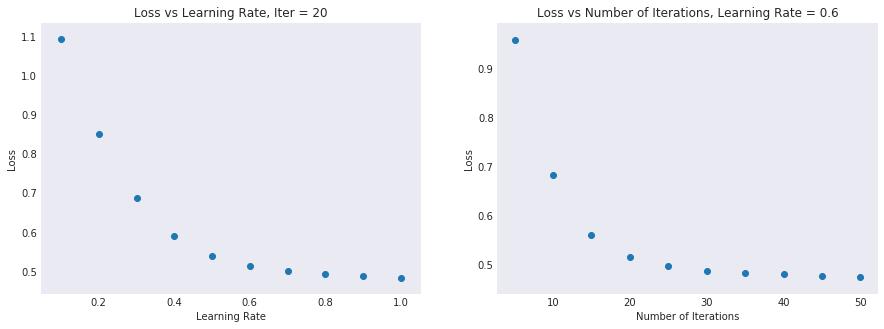

In [24]:
# Outputting the results
def processOptimizationResults(file):
    x = []
    y = []
    for r in file:
        if r != '' and 'Running' not in r:
            r = r.split('\t')
            x.append(round(float(r[0]),1))
            y.append(float(r[1]))

    return x,y

varLearning_x, varLearning_y = processOptimizationResults(open('logistic-test-lrV-iter20.txt','r').read().splitlines())
varIter_x, varIter_y = processOptimizationResults(open('logistic-test-lr6-iterV.txt','r').read().splitlines())

# Creating the graphs
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].set_title('Loss vs Learning Rate, Iter = 20')
axs[0].set_xlabel('Learning Rate')
axs[0].set_ylabel('Loss')
axs[0].scatter(varLearning_x, varLearning_y)
axs[1].set_title('Loss vs Number of Iterations, Learning Rate = 0.6')
axs[1].set_xlabel('Number of Iterations')
axs[1].set_ylabel('Loss')
axs[1].scatter(varIter_x, varIter_y)

From these results, the optimal settings seems to be around **0.6** for learning rate and for about **30** iterations. We move forward accordingly with these settings.

In [25]:
# Running on established settings
result = run_model(meanNormalizedRDD, valProcessedRDD, nSteps = 30, learningRate = 0.6, verbose = False)
print('Loss, Model, Stats:' + '\t' + str(result[0]) + '\t' + str(tuple(result[1])) + '\t' + str(result[2]) + '\n')

Loss, Model, Stats:	0.4864001186148145	(-1.2383276644535999, 0.6473552539616678, 0.0005480365910129348, -0.0377260036011038, -0.18107454302616127, 0.15544764278482745, 0.06576919564658262, 0.3826083848538125, 0.18243078374573604, 0.18399794740922223, 0.842376727346967, 0.08955086098879023, 0.26018276987610567, 0.06013495942523827)	{'Accuracy': 0.798, 'Recall': 0.396, 'Specificity': 0.934, 'Precision': 0.669, 'F1-Score': 0.498}



Another thing to try was the upsampling of data because the number of positives compared to negatives was quite significant was noted in the EDA. Our question is whether or not balancing the data by replicating some of the positive samples would help. The code for that is below. We try to upsample the positive data by 2x and 3x the original amount. 

In [26]:
# Upsampling the data
def upsampling_dataset(dataRDD, n):

    # Define the multiplier list
    multi_range = sc.broadcast(tuple(range(1, 2*n-1)))
    
    # Perform the upsampling on positive samples
    def multiply_data(line, n):
        
        # Establish random.choice parameters
        range_length = len(multi_range.value)
        prob = range_length*[1/range_length]
        
        # Multiply the lines
        if line[1] == 1:
            for i in range(int(np.random.choice(multi_range.value, size=1, replace=True, p=prob))):
                yield line
        else:
            yield line
    
    return dataRDD.flatMap(lambda x: multiply_data(x, n))

In [27]:
# Perform upsampling
upsampledRDD2 = upsampling_dataset(meanNormalizedRDD, 2)
upsampledRDD3 = upsampling_dataset(meanNormalizedRDD, 3)

In [28]:
# Run the model on 2x upsampling
result = run_model(upsampledRDD2, valProcessedRDD, nSteps = 30, learningRate = 0.6, verbose = False)
print('Loss, Model, Stats:' + '\t' + str(result[0]) + '\t' + str(tuple(result[1])) + '\t' + str(result[2]) + '\n')

Loss, Model, Stats:	0.5368033372368641	(-0.8717575907104784, 0.6613240557323669, -0.0021495364553390604, -0.047069969811890426, -0.1729183639205648, 0.14698101657201432, 0.06860334755622685, 0.37855288834289685, 0.18620522068544218, 0.20549467858533385, 0.8970371857752129, 0.0879901345499235, 0.2625967197816698, 0.05599697079113881)	{'Accuracy': 0.792, 'Recall': 0.55, 'Specificity': 0.874, 'Precision': 0.595, 'F1-Score': 0.572}



In [29]:
# Run the model on 3x upsampling
result = run_model(upsampledRDD3, valProcessedRDD, nSteps = 30, learningRate = 0.6, verbose = False)
print('Loss, Model, Stats:' + '\t' + str(result[0]) + '\t' + str(tuple(result[1])) + '\t' + str(result[2]) + '\n')

Loss, Model, Stats:	0.575865509836656	(-0.374289350720725, 0.6911148081720686, 0.01842609074994411, -0.04386867819529098, -0.1746797162593374, 0.14363860543371731, 0.07319758609158657, 0.379307496439588, 0.20130186020002294, 0.21816822359095545, 0.9457491941916547, 0.09295176213039376, 0.27268392074688286, 0.05405840510298003)	{'Accuracy': 0.73, 'Recall': 0.768, 'Specificity': 0.716, 'Precision': 0.478, 'F1-Score': 0.589}



It can seen with the above that upsampling positive values helps recall tremendously while the accuracy stays relatively constant. There is minor loss with a 3x unsampling. The specificity dips throughout though as upsampling increases however even at 3x upsampling the specificity is still at parity with recall. Therefore, it overall seems like we're rebalancing the algorithms ability to detect positive samples. The f1-score which is a uniformity metric between recall and precision also increases slightly showing measurable gains. Therefore, it is suggested that an upsampling of 3 is used.

#### Validating Using Gradient Boosted Trees

In [33]:
trainRDD = meanNormalizedRDD.map(lambda x: LabeledPoint(x[1], x[0]))
testRDD = valProcessedRDD.map(lambda x: LabeledPoint(x[1], x[0]))
print("Data set as mean MLlib object")

Data set as mean MLlib object


#### Gradient Boosting Tree Model

In addition to logistic regression for model the click-through data, we also explored using decision trees, which we explored through leveraging the pyspark mllib libraries to train our models. Within mllib tree libraries, both random forest and gradient boosted tree ensemble methods were available, however our team decided to focus on using GBT because it is better at handling unbalanced datasets. The primary difference between the two is that random forest is a bagging method algorithm which means it doesn't focus on samples that for instance may have been heavily misclassified like a boosting algorithm would.

Because the categorical features have been turned into ordinal bins and then regularized, no features were identified as categorical features. For hyperparameter tuning, we used the test data subset to do this, before running on the full dataset. With hyperparameter tuning, we adjusted for different number of trees, depth of trees, number of bins and learning rate. From these adjustments, we found the model defaults to still perform best (learning rate = 0.1, depth of trees = 3, number of bins = 32, number of trees = 100). For the loss function, logLoss was used since we are predicting classification data and not regression, which squared error and absolute error are more suited for. This also aligns with the loss for logistic regression.

In [34]:
# Using MLLib GradientBoostedTrees library, we generate a model 
# using our training data and tuned hyperparameters
model = GradientBoostedTrees.trainClassifier(modelRDD, 
                                             categoricalFeaturesInfo={}, 
                                             loss="logLoss", 
                                             numIterations=100, 
                                             learningRate=0.1, 
                                             maxDepth=3, 
                                             maxBins=32)

In [38]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Evaluation predictions

predictions = model.predict(testRDD.map(lambda x: x.features))
labelsAndPredictions = testRDD.map(lambda lp: lp.label).zip(predictions)
testAcc = labelsAndPredictions.filter(lambda lp: lp[0] == lp[1]).count() / float(testRDD.count())

metrics = MulticlassMetrics(labelsAndPredictions)

# Evaluation Metrics
cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

print("GradientBoostedTrees:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1 Score:", f1_score)

GradientBoostedTrees:
Accuracy:  0.8125
Precision:  0.9244147157190635
Recall:  0.8406326034063261
f1 Score: 0.8805352022937241


Here, we see that gradient boosted trees out performs logistic regression in all regards. The metrics indicate that they are able to better differentiate positive and negative values. These results using an initial 10K dataset are encouraging. We proceed accordingly to run the full dataset using both algorithms. We briefly note our architecture as well and some performance considerations.

## Running Against All Data in the GCP Cluster:


####                Note: This section content (Code & Output) is copied from the GCP notebook that was used to run on the dataproc cluster.


#### Data Loading

The training data was initially downloaded and unzipped into the google bucket. 

In [ ]:
trainRDD = sc.textFile('gs://<bucket>/btrain.txt')
sampleTrainRDD = trainRDD
valRDD = sc.textFile('gs://<bucket>/valdata.txt')

#### Data Preprocessing

All the preprocessing we have done based on the EDA for feature selection was run on the full dataset by calling the below function.

In [1]:
# Note that this process is the same as above. Re-presented to show process consistency.
def prepare_data(dataRDD):
    dataRDD = dataRDD.map(lambda x: parse(x, 'test')).cache()
    avg_list, max_list, min_list = makeAvgMaxMin(dataRDD)
    dataRDD = replaceNoneWithMean(dataRDD, avg_list)
    dataRDD = bin_convert(dataRDD, [15, 19, 21, 27, 30,31, 35, 36, 38], 100)
    dataRDD = dataStaging(dataRDD, column_choices)
    dataRDD = normalizeMean(dataRDD)
    
    return dataRDD

In [ ]:
trainRDD = prepare_data(trainRDD)

#### Performance Considerations

##### Parquet Files Vs Text Files

We have initially tested with the data in the text files. Then we converted the data files into a parquet file and we noticed significant performance improvements on the basic action such as counting the number of rows. Dataframe created from the parquet file seemed to be the highly performant than the RDD converted from the Dataframe which was created from the parquet file. Since we wanted to demonstrate the usage of the low level APIs such as RDDs , our algorithm was implemented using RDDs not using Dataframes. 

In [ ]:
workingRDD = trainRDD.map(parse).cache()
trainDF = sqlContext.createDataFrame(workingRDD)
trainDF.write.parquet('gs://<bucket>/ads.parquet')


In [ ]:
data_parquet = spark.read.parquet("gs://<bucket>/ads.parquet")
data_rdd = data_parquet.rdd.map(list)

In [ ]:
start = time.time()
print(trainDF.count())
print(f'... completed job in {time.time() - start} seconds.')

In [ ]:
start = time.time()
print(data_parquet.count())
print(f'... completed job in {time.time() - start} seconds.')

start = time.time()
print(data_rdd.count())
print(f'... completed job in {time.time() - start} seconds.')

#### Caching & Object storing 

After all the pre-processing steps are done , we saved the data into pickle file in the bucket and reused it for multiple hyper parameter tuning. This way we didn't have to keep the cluster running for longer period and this helped us to fine tune the right model with the appropriate hyper-parameters. We also cached the data using .cache() after any major transformation. That helped to boost the performance instead of evaluating the lineage of all the transformations from the beginning every time.

In [ ]:
# THe code to save as pickle file
trainRDD.saveAsPickleFile('gs://<bucket>/modelRDD.pickle', 6)

In [ ]:
trainRDD = sc.pickleFile('gs://<bucket>/modelRDD.pickle')
trainRDD = trainRDD.cache()

#### Logistics Regression (GCP Run):

With the insight seen from our prior run with 10 000 rows of data, we run logistic regression again on the full dataset.

In [ ]:
testRDD, trainRDD = trainRDD.randomSplit(weights=[0.2, 0.8], seed=1)

result = run_model(trainRDD, testRDD, nSteps = 30, learningRate = 0.6, verbose = False)
print('Loss, Model, Stats:' + '\t' + str(result[0]) + '\t' + str(tuple(result[1])) + '\t' + str(result[2]) + '\n')

Loss, Model, Stats:    0.536658681618232    (-1.1210867873869728, 0.8637251669737724, 0.017576869179104223, 0.05426938571757589, -0.11888924059063082, 0.07350756742309478, 0.06381750556185158, 0.17260005118932126, 0.17288374042464336, 0.2231436227747079, 0.372095576500797, 0.08047750398824605, 0.2578600132298404, 0.03715062873595507)    {‘Accuracy’: 0.736, ‘Recall’: 0.125, ‘Specificity’: 0.942, ‘Precision’: 0.423, ‘F1-Score’: 0.193}

In [ ]:
# Upsampling the full dataset as explained above.
trainRDD2 = upsampling_dataset(trainRDD, 2)
testRDD, trainRDD = trainRDD2.randomSplit(weights=[0.2, 0.8], seed=1)

result = run_model(trainRDD, testRDD, nSteps = 30, learningRate = 0.6, verbose = False)
print('Loss, Model, Stats:' + '\t' + str(result[0]) + '\t' + str(tuple(result[1])) + '\t' + str(result[2]) + '\n')

In [ ]:
trainRDD3 = upsampling_dataset(trainRDD, 3)

testRDD, trainRDD = trainRDD3.randomSplit(weights=[0.2, 0.8], seed=1)

result = run_model(trainRDD, testRDD, nSteps = 30, learningRate = 0.6, verbose = True)
print('Loss, Model, Stats:' + '\t' + str(result[0]) + '\t' + str(tuple(result[1])) + '\t' + str(result[2]) + '\n')

#### Gardient Boosted Tree (GCP Run):

In [ ]:
testRDD, trainRDD = trainRDD.randomSplit(weights=[0.2, 0.8], seed=1)

In [ ]:
model = GradientBoostedTrees.trainClassifier(trainRDD, 
                                             categoricalFeaturesInfo={}, 
                                             loss="logLoss", 
                                             numIterations=100, 
                                             learningRate=0.1, 
                                             maxDepth=3, 
                                             maxBins=32)

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Evaluation predictions

predictions = model.predict(testRDD.map(lambda x: x.features))
labelsAndPredictions = testRDD.map(lambda lp: lp.label).zip(predictions)
testAcc = labelsAndPredictions.filter(lambda lp: lp[0] == lp[1]).count() / float(testRDD.count())

metrics = MulticlassMetrics(labelsAndPredictions)

# Evaluation Metrics
cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
f1_score = 2 * (precision * recall) / (precision + recall)

print("GradientBoostedTrees:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("f1 score:", f1_score)

GradientBoostedTrees: 

Accuracy: 0.7661624563401778 

Precision: 0.9491640848788224 

Recall: 0.7826352776591122

f1 score: 0.8578930252342352

#### Observation and Discussion

Having run both algorithms on the full dataset, there are a few interesting observations to note. On the topic of logistic regression, with 3x upsampling we achieved a model of:

$z = 0.205 + 0.882C_{3} + 0.061C_{6} + 0.046C_{8} - 0.101C_{9} + 0.064C_{15} + 0.065C_{19} + 0.164C_{21} + 0.174C_{27} + 0.255C_{30} + 0.395C_{31} + 0.089C_{35} + 0.262C_{36} + 0.025C_{38}$

where $z$ plugs into the sigmoid function as mentioned previously. Looking at this model it seems that columns 6, 8, 15, 19, 35, and 38 contribute relatively less weight to the overall prediction. Given our previous EDA, there doesn't seem to be any obvious trends that stand out between the coefficient of these variables and they may just represent fine-tuning variables. Its interesting to note as well that only column 9 shows a negative effect on the overall probability. This could mean that many of the provided features are features of some type of positive engagement. However, without further information, it is hard to say for certainty. Another interesting observation would be that if all these variables were null or 0, the bias term of 0.205 would lead to a predicted probability of about 0.445 of not clicking.

For logistic regression we also saw performance statistics of {'Accuracy': 0.559, 'Recall': 0.776, 'Specificity': 0.447, 'Precision': 0.42, 'F1-Score': 0.545} when doing 3x upsampling. Compared to running on the 10K row dataset, these results are not as good. All metrics aside from recall are significantly lower though the effect of raising recall and f1-score and lowering accuracy, specificity, and precision persists. It seems that the metrics are particularly more sensitive with larger datasets. Note the difference when upsampling from 2x to 3x versus 1x to 2x. This is interesting though as it could suggest a point at which the number of certain values in certain features will start forcibly directing the probability towards a certain class. Looking at the equation from 2x upsampling

$z = -0.732 + 0.864C_{3} + 0.004C_{6} + 0.034C_{8} - 0.104C_{9} + 0.067C_{15} + 0.064C_{19} + 0.159C_{21} + 0.169C_{27} + 0.245C_{30} + 0.386C_{31} + 0.077C_{35} + 0.254C_{36} + 0.030C_{38}$

we see there are coefficients that change quite significantly. Notably, the bias term, which has a completely different sign and column 6 which increased by approximately 15x from 0.004 to 0.061 when doing 3x upsampling. Therefore we suggest that the feature represented by column 6 might have an underlying influence on CTR though strangely, the correlation plot doesn't seem to indicate any association. When upsampling, the change in the sign of the bias term may also indicate that we're capturing an unexpected new or related effect as well. Again, without knowing what these columns represent, it is hard to say for sure.  

When comparing our metrics to gradient boosted trees, the tree seems to have greatly out-performed the logistic model. The accuracy is comparable to our logistic model with no unsampling but all other metrics seem to be much better on the tree versus. This is consistent with results mentioned in the article pointed out in the introduction. Since gradient boosting trees essentially "parameterize" on the trees themselves instead of a model's parameters like logistic regression, it is methodically improving at a higher level with each iteration versus logistic regression which improves by finding the local minima to which there could be many. As we were conducting our experiments, we did notice that the logistic model's initial parameters did make a difference. Another weakness of logistic regression could be in how we selected the features. We saw that many features are not normally distributed and that logging them might reduce the amount of data since many features contain lots of 0s. Trees avoid this because we are essentially setting a cutoff at each tree node to divide the data by. This makes trees much more dynamic in how it handles the feature space. As the evidence indicates, our thought here is that gradient boosting methods such as the boosted trees implemented here are more effective than logistic regression.

#### Application of Core Concepts

1) Breiman Method and Binning: 

For our categorical features, we explored several approaches for how to best address this so that we could use this data in training our models. As the data is anonomized, we lacked significant context on what these features represented and how best to interpret them. In addition, several features were very diverse in the number of unique categories that they had. The method we decided to use was the Breiman method that would converting categorical data that we assumed are unordered into ordinal values based on each category's proportion of click-through rate. For example, if 80% of records labeled category A in a feature are positive click-throughs and 40% of records labeled category B are positive click-throughs, then we can say that A > B.  

After ordering the category values for the categorical features we decided to use, we further decided to bin the values to shrink the dataset. This decision was made with the objective of reducing the noise from features with many unique categories. All category values were split into ordered groupings for each bin and our output data merged back into the dataset contained only the ordered bin number of the original category value. In this way, we were able to convert unordered categorical feature with many distinct values into an ordinal, simplified and smooth feature instead.

2) Loss and Gradient Descent:

In order to implement the logistic regression model, we had to leverage the concept of loss and the method of gradient descent. The loss of logistic regression is given by cross-entropy, a calculation which punishes unmatched predictions quite severely. It works by applying log to the sigmoid of the regressed expression and multiplying by the predicted result. In this case though the predicted result is binary and we don't want to eliminate the loss when the prediction is false therefore we subtract 1 from the result to get the opposing probability. The overall loss is then the average across all individual losses of each data point.

Cross-entropy also has a simple derivative that can be applied. In its final form, each step is essentially the predicted probability minus the actual value summed together. This is then passed to all data points and multiplied by a learning rate. Gradient descent is an iterative process therefore this step is done until some type of convergence is seen.

Here we optimized for both the learning rate and the number of iterations and found that on our training set, convergence happens after about 30 iterations at a learning rate of 0.6.

3) Broadcasting:

Throughout this project, there were several times when broadcasting had to be done. Broadcasting is a method where different partitions can access values even if those values are not directly stored in the partition. This is a huge benefit in terms of speed because otherwise values would have to copied into partitions as well which could be an expensive process depending on the size of the variable and the number of partitions there are.

4) Scalability: 

One of the main challenges we noticed while building our model is the fact that including columns with many distinct values tends to slow down our algorithm quite significantly. This is likely because of the shuffling step in MapReduce. With more distinct values, spark would likely have to spend more time partitioning appropriately. Therefore depending on the resources available, this can be a significant drawback. 

To run the algorithms to run on the full data set , we used the GCP clusters with the techniques to cache the data , broadcast the smaller datasets and also store the objects to the external bucker for repeated runs.

5) Normalization:

One of the steps in our process is to do mean normalization. This involves taking the difference between each value, its respctive field average and dividing it by its respective field standard deviation. This is very important to do especially in cases of regression because otherwise, gradient descent may not be able to converge since the dimensions of the dataspace are not on the same scale. This causes local minima to potentially be missed as the descent iterates through.


#### Conclusion

To recap, we firstly made a training set of 10K values from the original dataset provided by criteo labs. We noticed that the data was filled with null values. This was potentially problematic for us since the modeling process and any potential algorithm we would use is based on the nature of the data. Therefore we wanted to investigate how prevalent this observation was. We found the overall phenomenon to vary between columns. Some did not contain any null values whereas others contained a lot such as column 12 with 77% and 35 with 76%. Next, we decided to look at how many distinct values there were. This was driven mostly by the dataset being comprised mostly of categorical features. As with null values, the results varied per column. Some were high while others were low. In terms of numerical variables, we also decided to look into each variables distribution and correlation. We ultimately went with a mixed bag approach ultimately selecting for variables that were low in multi-colinearity and decently diverse enough to capture some variance but not granular enough to make computation heavy. We also went with column 35 which had a high degree of nulls to add a degree of unconventionality. 

With these features, we ran both logistic regression and gradient boosted trees on both the sampled 10K dataset and the full dataset. For logistic regression, different levels of upsampling was also tried. We saw a trade-off happen between recall and specificity as the amount of positive samples increased. This effect was mild when running on the 10K dataset but was very pronounced in the full dataset. At first, these shifts were thought to be indicative of data points that were on the fringe of being predicted one class versus another as upsampling increased. However with the full dataset, it was noticed that some columns such as column 6 and the bias term had changed from upsampling versus other columns. This could be indicative of some meaning between this particular variable and the label though the initial correlation plot again, didn't show strong association. It would be interesting to further pursue this.

Overall though, in our effort to compare models, it does seem that decision trees greatly outperformed logistic regression. We saw improvements in virtually every metric. Again, this is likely due to how trees handle the feature space and also that with a boosting algorithm, the trees get successively better with each iteration and this is usually seen relatedly as a weighted process. For problems of this nature, we can foresee gradient boosting trees as a more reliable method.

In terms of future directions, there are several things that can be tried. In terms of feature selection, an L1 norm can be applied to reduce the number of numeric features. Another thing to possibly look at are interaction terms. For example, some of the variables could be different forms of quantity, which has to be multiplied by another feature to get the full picture. In terms of transformations, principal component analysis (PCA) can be used to generate fields with higher variance. This could in essence concentrate more variance into a smaller number of features. Also, the number of bins is another parameter that can be tuned. We chose 100 arbitrarily in this case. In terms of modeling, different loss functions and algorithms can be tried. For instance, stochastic gradient descent might get the algorithm to converge faster and mllib has a host of different algorithms to try. In all, there are many directions that one could take this effort further. Our work demonstrates one potential avenue this problem can be approached.

##### Appendix 1: Supplementary Info/Code Used

In [ ]:
# Code 1:
"""
This was used to verify the contents of the column by checking the datatype
"""
test.dtypes

In [ ]:
# Code 2:
"""
This was used to check that even if columns had the same number of nulls, the non-value values don't match up.
"""
test[[33,34]].sort_values(by=[33,34]).head(10)

/opt/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


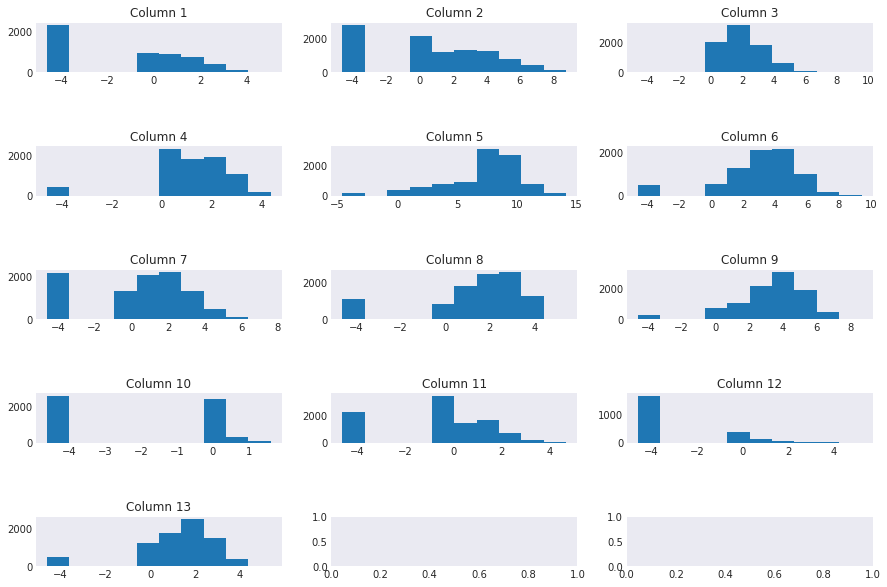

In [135]:
# Code 3:
"""
This line was ran to generate the logged version of numeric variables.
"""
hist_grid((test[list(range(1,14))]), 5, 3, log = True)

In [ ]:
def distinctCounts(line): 
    for i in range(14, 40): 
        yield (i, line[i])

distinct_list = workingRDD.flatMap(distinctCounts).distinct().map(lambda x: (x[0], 1)) \
                          .reduceByKey(lambda x,y: x+y).toDF().toPandas()

distinct_list.columns = ["Column Index", "Distinct Values"]
distinct_list.index = distinct_list["Column Index"]
distinct_list.drop(["Column Index"], 1, inplace=True)
distinct_list.index.names = ['Feature Index']

display(HTML(distinct_list.sort_index().transpose().to_html()))

In [ ]:
def countNulls(line): 
    for i in range(14): 
        if line[i] is None: 
            yield ((i, 0), 1)
        else: 
            yield ((i, 1), 1)
            
    for i in range(14, 40): 
        if line[i] == 0: 
            yield ((i, 0), 1)
        else: 
            yield ((i, 1), 1)

nRecords = workingRDD.count()
null_info = workingRDD.flatMap(countNulls).reduceByKey(lambda x,y: x+y).collect()
null_counts = [0.0 for i in range(40)]
non_null_counts = [0.0 for i in range(40)]
null_pct = [0.0 for i in range(40)]

for thing in null_info: 
    if thing[0][1] == 0: 
        null_counts[thing[0][0]] = thing[1]
        null_pct[thing[0][0]] = thing[1] / nRecords
    else: 
        non_null_counts[thing[0][0]] = thing[1]
        
null_infos = pd.DataFrame({"Non Null Counts": non_null_counts, "Null Counts": null_counts, "Null Percentage": null_pct})
null_infos.index.names = ['Feature Index']

display(HTML(null_infos.transpose().to_html()))

In [ ]:
## This code was used to find the optimal settings for logistic regression

for x in range(1,11):
    print("Running learning rate at " + str(x*0.1))
    out_data = run_model(meanNormalizedRDD, valProcessedRDD, nSteps = 20, learningRate = x*0.1, verbose = False)
    print(str(x*0.1) + '\t' + str(out_data[0]) + '\t' + str(tuple(out_data[1])) + '\t' + str(out_data[2]) + '\n')


for x in range(5,51,5):
    print("Running step size at " + str(x))
    out_data = run_model(meanNormalizedRDD, valProcessedRDD, nSteps = x, learningRate = 0.6, verbose = False)
    print(str(x) + '\t' + str(out_data[0]) + '\t' + str(tuple(out_data[1])) + '\t' + str(out_data[2]) + '\n')

In [ ]:
# Functions used to conver categorical features into one-hot encodings

# Use this after transformations to convert each record into one long list
def unfurl_list (line): 
    output = []
    for i in line: 
        if i is not list: 
            output.append(i)
        else
            output.extend(i)
            
    return output

# This function is used in the one-hot mapper to conver the category value into a list of 0's and 1
def val_to_list (line, index, distinct_list): 
    if line[index] is None: 
        return line
    
    new_list = [0] * len(distinct_list)
    new_list[ distinct_list.index(line[index]) ] = 1
    line[index] = new_list
    
    return line

# Function called for each column
def col_one_hot (dataRDD, index):
    # Assumption: number of distinct values isn't crazy big
    distinctRDD = dataRDD.map(lambda x: (x[index], 1)).distinct().count()
    count = distinctRDD.count()
    
    if count < 1000:
        # Gets distinct values ordered in list and converts to one-hot encoding
        distinct_list = distinctRDD.sortByKey(True).map(lambda x: x[0]).collect()
        oneHotRDD = dataRDD.map(lambda x: val_to_list(x, index, distinct_list))
        
        return oneHotRDD
        
    return dataRDD

# Main function that will iterate over all features to be transformed
def one_hot(dataRDD, index_list):
    newRDD = dataRDD
    for i in index_list: 
        newRDD = col_one_hot(newRDD, i)
    
    return newRDD

##### Appendix 2: Code Junkyard (No insights drawn from these but kept here in case needed)

In [ ]:
def fill_none_average(dataRDD):
    
    def calculate_sum(a,b):
        for [a]
    
    avgRDD = dataRDD.reduce(lambda a,b: a+b)
    
    return avgavgRDD

from pyspark.sql.functions import col, when

def blank_as_null(x):
    return when(x == "", x).otherwise(None)

df = toyRDD.map(parse).toDF()
dfWithEmptyReplaced = df.select(*(blank_as_null(col(c)).alias(c) for c in df.columns))

dfWithEmptyReplaced.show()

In [ ]:
def normalizeRange(dataRDD):
    
    def find_min(a,b):
        out = tuple()
        for i,v in enumerate(a):
            if b[i] < v:
                out += (b[i], )
            else:
                out += (v, )
        
        return a
        
    
    featureMin = dataRDD.reduce(lambda a,b: find_min(a,b))
    #featureMax = dataRDD.map(lambda x: x[0]).max()
    
    return featureMin
    
    #normedRDD = dataRDD.map(lambda x: ((x[0] - featureMeans)/featureStdev, x[1]))

In [ ]:
workingRDD2 = logColumns(workingRDD)

In [ ]:
def logColumns(dataRDD):
    
    def log_it(line):
        for v in range(1,14):
            line[v] = np.log(line[v])
            
        return line
    
    return dataRDD.map(lambda x: log_it(x))

In [ ]:
def transform_numeric(line, columns_to_drop = None, columns_to_normalize = None, columns_to_log = None):
    
    
    def columns_to_log(line, columns_to_log):
        out_tuple = tuple()
        
        
    
    if column_list is None:
        return np.nan_to_num(line[1:])
    else:
        return [np.nan_to_num(x) for i,x in enumerate(line) if i in column_list]

column_list = [2,8]
workingRDD = toyRDD.map(parse).map(lambda x: (np.array(get_columns(x, column_list)), x[0]))